In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
#Importing the data set
df=pd.read_csv('perrin-freres-monthly-champagne-.csv' )

In [42]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [43]:
df.dropna(inplace=True)

In [44]:
df.columns=['Month','Sales']

In [45]:
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [7]:
#Right now, we have values in our month’s column in string objects. 
#We will be required to change it on the DateTime object, and also we need to make it our index column

In [46]:
df['Month']=pd.to_datetime(df['Month'])

In [47]:
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [48]:
df.set_index('Month', inplace=True)

In [49]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [12]:
#Describing the sales column
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


<AxesSubplot:xlabel='Month'>

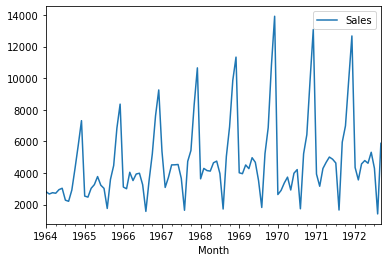

In [13]:
#Making a line graph for visualization of the data
df.plot()

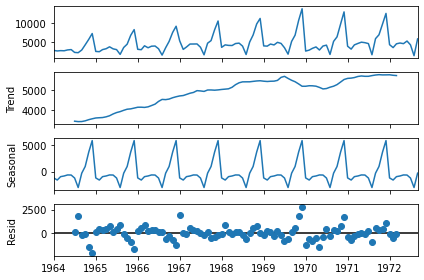

In [14]:
#Decomposing the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(df, model="additive")
decompose_data.plot();

Here we can see that the range of trend and residual is nominal, 
or we can say that trend is having variation between 4000 to 5000, and most of the time residual is having the variation around.
But for the seasonality, we can see that it varies between 0 to 5000, which is a high difference range.

<AxesSubplot:xlabel='Month'>

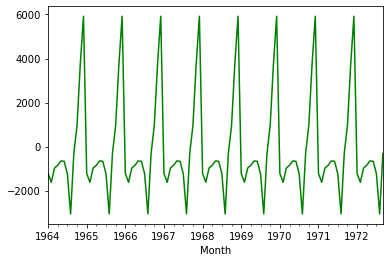

In [15]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

To know more about the time series stationarity, we can perform the ADfuller test, a test based on hypothesis, where if the p-value is less than 0.05, then we can consider the time series is stationary, and if the P-value is greater than 0.05, then the time series is non-stationary.

In [16]:
#Creating a function for ADfuller test

from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales, autolag='AIC')
    labels=['ADF', 'p value', 'Lags','Nob','critical values']
    for value, label in zip(result, labels):
        print(label+':'+ str(value))
       

In [17]:
adfuller_test(df['Sales'])

ADF:-1.8335930563276195
p value:0.3639157716602467
Lags:11
Nob:93
critical values:{'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}


Here it is clear that p value is greater than 0.05 and the data is not stationary. We can make the time series stationary with differencing methods. In this case, we are going ahead with the rolling mean differencing methods.

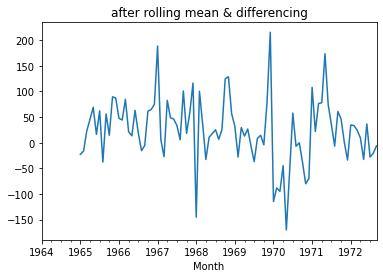

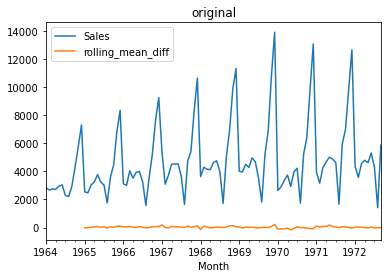

In [18]:
#Appling the rolling mean differencing

rolling_mean = df.rolling(window = 12).mean()
df['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
df['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
df.plot(title='original');

Here we can see in the graph the seasonality of before the differencing and after the differencing. We can see that we have reduced a lot of seasonality. 

In [19]:
rolling_mean.head(15)

,Sales
Month,
1964-01-01,NaN
1964-02-01,NaN
1964-03-01,NaN
1964-04-01,NaN
1964-05-01,NaN
1964-06-01,NaN
1964-07-01,NaN
1964-08-01,NaN
1964-09-01,NaN


In [20]:
rolling_mean.shift().head(15)

,Sales
Month,
1964-01-01,NaN
1964-02-01,NaN
1964-03-01,NaN
1964-04-01,NaN
1964-05-01,NaN
1964-06-01,NaN
1964-07-01,NaN
1964-08-01,NaN
1964-09-01,NaN


In [21]:
#Doing ADfuller test with rolling mean difference column

adfuller_test(df['rolling_mean_diff'].dropna())

ADF:-7.626619157213173
p value:2.0605796968135582e-11
Lags:0
Nob:92
critical values:{'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}


Now the p-value is near about zero and very less than 0.05; now, our time series is stationary. Next step is to plot ACF and PACF graph to finding P and Q values

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

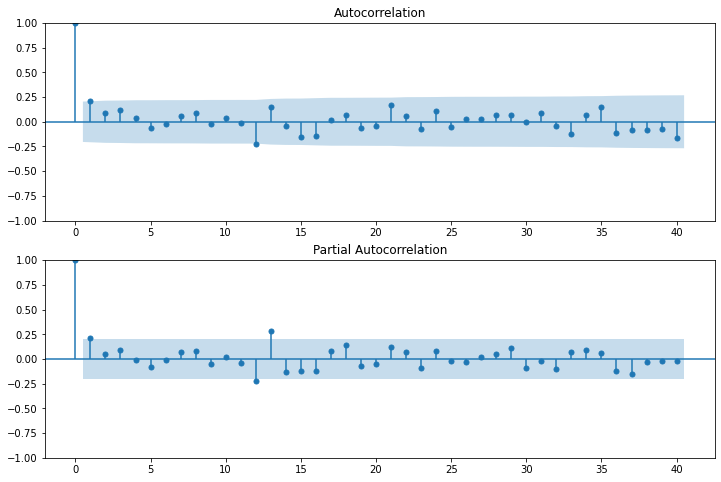

In [23]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=plot_acf(df['rolling_mean_diff'].iloc[13:], lags=40, ax=ax1)
ax2=fig.add_subplot(212)
fig=plot_pacf(df['rolling_mean_diff'].iloc[13:], lags=40, ax=ax2)

From the graph p=1, q=1 

Now we can move to the modelling side. First we are implementing ARIMA model, which is the advanced version of ARMA

In [24]:
from statsmodels.tsa.arima.model import ARIMA

 First implementating  the model without differencing.

In [25]:
model=ARIMA(df['Sales'],order=(1,1,1))
history=model.fit()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [26]:
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Fri, 16 Jun 2023   AIC                           1911.627
Time:                        10:33:37   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Month'>

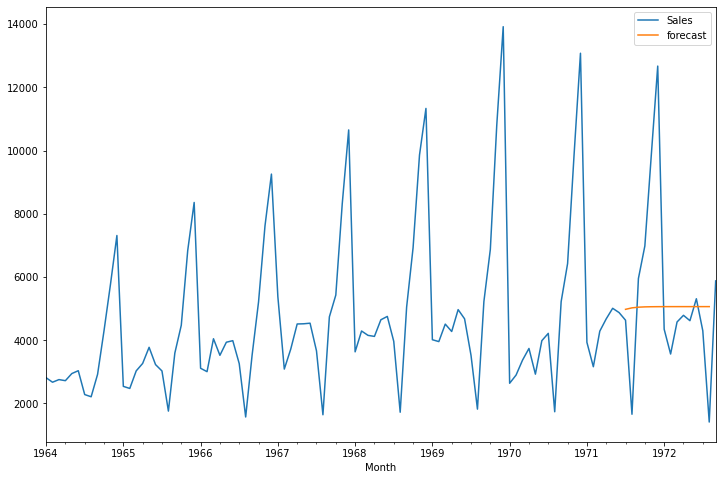

In [27]:
#Testing of the model
df['forecast']=history.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

Here we can easily see the results we have got by the model is very unsatisfactory. This is because we have fit the model with a non-stationary time series. Without the stationary data, the model is not going to perform well. 

Next, we are going to apply the model with the data after differencing the time series.

In [28]:
model=ARIMA(df['rolling_mean_diff'].dropna(),order=(1,1,1))
model_fit=model.fit()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='Month'>

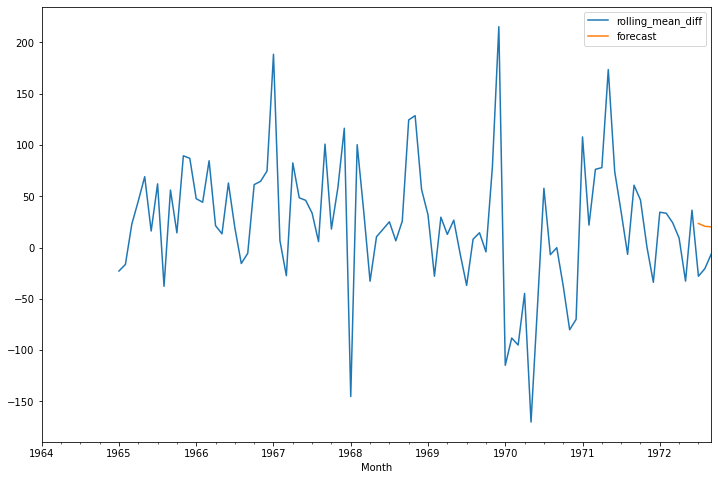

In [29]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['rolling_mean_diff','forecast']].plot(figsize=(12,8))

When using data after differencing the result is more better than using data without differencing. But the result we got is not satisfactory. This is because the seasonality of data is affecting the data. So to get rid of the situation, we can use the SARIMAX model.

In [30]:
#Importing the package where the model is available
import statsmodels.api as sm

In [31]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Fri, 16 Jun 2023   AIC                           1486.804
Time:                                    10:45:14   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.61   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Month'>

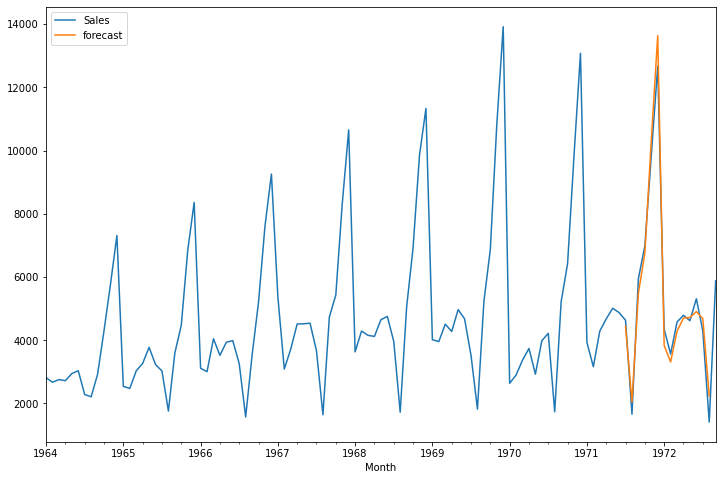

In [33]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

Here in the graph, we can see the results: the forecasting line is almost lying on the given values for this model. We didn’t even require the differencing method. Using this model now, we can predict the future values too

For predicting sales data for next 2 years(24 months)

In [34]:
from pandas.tseries.offsets import DateOffset
pred_date=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [35]:
df.index[-1]

Timestamp('1972-09-01 00:00:00')

In [36]:
pred_date

[Timestamp('1972-09-01 00:00:00'),
 Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-11-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-08-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00'),
 Timestamp('1973-11-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1974-01-01 00:00:00'),
 Timestamp('1974-02-01 00:00:00'),
 Timestamp('1974-03-01 00:00:00'),
 Timestamp('1974-04-01 00:00:00'),
 Timestamp('1974-05-01 00:00:00'),
 Timestamp('1974-06-01 00:00:00'),
 Timestamp('1974-07-01 00:00:00'),
 Timestamp('1974-08-01 00:00:00')]

In [37]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=df.columns)
pred_date

,Sales,rolling_mean_diff,forecast
1972-10-01,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN
1973-03-01,NaN,NaN,NaN
1973-04-01,NaN,NaN,NaN
1973-05-01,NaN,NaN,NaN
1973-06-01,NaN,NaN,NaN
1973-07-01,NaN,NaN,NaN


In [38]:
#To make forecasted values, we need to concate this blank data with our alcohol sales data.
df=pd.concat([df,pred_date])

In [39]:
df.tail()

,Sales,rolling_mean_diff,forecast
1974-04-01,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN


<AxesSubplot:>

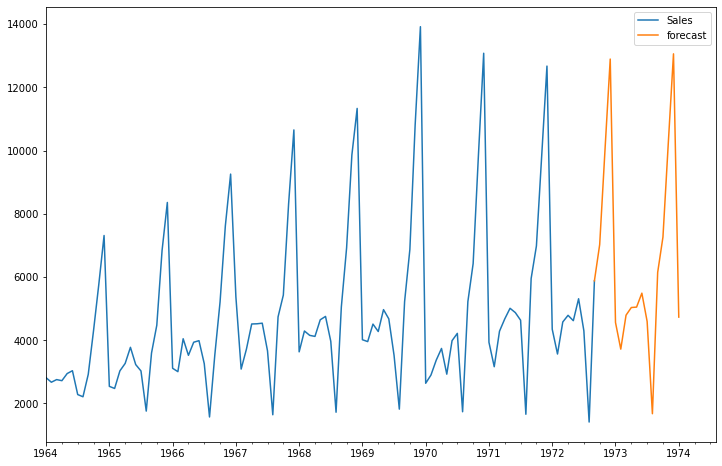

In [40]:
#Making the prediction using the model we have created before.
df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
df[['Sales', 'forecast']].plot(figsize=(12, 8))

We can see that the model has predicted the values without compromising with the seasonality effects and exogenous factors. And the trend line is almost going as usual as it was going in past years.

To check Root mean square value we split the data into train and test

In [60]:
train=df[:-12]
test=df[-12:]

In [51]:
sales_forecast=results.forecast(steps=12)

In [59]:
sales_forecast

1972-10-01     7023.698829
1972-11-01     9996.175856
1972-12-01    12891.998307
1973-01-01     4561.379485
1973-02-01     3718.694662
1973-03-01     4792.239971
1973-04-01     5034.490036
1973-05-01     5047.836417
1973-06-01     5488.452945
1973-07-01     4593.507795
1973-08-01     1676.018471
1973-09-01     6144.750513
Freq: MS, Name: predicted_mean, dtype: float64

In [61]:
test

,Sales
Month,
1971-10-01,6981.0
1971-11-01,9851.0
1971-12-01,12670.0
1972-01-01,4348.0
1972-02-01,3564.0
1972-03-01,4577.0
1972-04-01,4788.0
1972-05-01,4618.0
1972-06-01,5312.0


When we compare the test data sales values and forecast value actual value and forecast values are pretty close. Let's check the RMSE value

In [54]:
from sklearn.metrics import mean_squared_error

In [56]:
Rmse=np.sqrt(mean_squared_error(test['Sales'],sales_forecast))
print(Rmse)

240.28077157560435


In [ ]:
Root mean 